In [41]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np 
import re
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv("C:/Users/Admin/Desktop/drom_webscraping.csv")
data = df.copy()
data.head()

,Link,Title,Subtitle,Description,Price,Location
0,https://auto.drom.ru/moscow/mercedes-benz/c-cl...,"Mercedes-Benz C-Class, 1997",NaN,"2.0 л (136 л.с.),бензин,механика,задний,345 80...",200 000,Москва
1,https://auto.drom.ru/novosibirsk/mercedes-benz...,"Mercedes-Benz C-Class, 1995",C200 АT Elegance,"2.0 л (136 л.с.),бензин,АКПП,задний,290 000 км",198 000,Новосибирск
2,https://auto.drom.ru/novosibirsk/mercedes-benz...,"Mercedes-Benz A-Class, 2002",A 160,"1.6 л (102 л.с.),бензин,АКПП,передний,397 000 км",185 000,Новосибирск
3,https://auto.drom.ru/novosibirsk/mercedes-benz...,"Mercedes-Benz E-Class, 1989",200 E MT5 Base,"2.0 л (122 л.с.),бензин,механика,задний,152 00...",150 000,Новосибирск
4,https://auto.drom.ru/vladivostok/mercedes-benz...,"Mercedes-Benz Mercedes, 1992",NaN,"2.5 л (90 л.с.),механика,задний,50 000 км",110 000,Владивосток


In [4]:
data.shape

(14128, 6)

In [5]:
data = data.rename(columns={"Title":"Car Title"})
data[['Car', 'Year']] = data['Car Title'].str.split(', ', expand=True)
data["Year"] = pd.to_numeric(data['Year'], errors='coerce')

In [6]:
def parse_specs(spec):
    engine = fuel = transmission = drive = mileage = color = np.nan
    
    # split into comma-separated parts
    parts = [p.strip().lower() for p in spec.split(",")]
    
    # dictionaries/lists
    fuels = ["бензин", "дизель", "электро", "гибрид", "газ"]
    transmissions = ["механика", "акпп", "робот", "вариатор", "автомат"]
    drives = ["передний", "задний", "полный", "4wd"]
    colors = ['синий', 'серый', 'серебристый', 'белый', 'черный', 'зеленый',
              'красный', 'коричневый']
    
    # ---- ENGINE VOLUME ----
    vol = re.search(r"([\d\.]+)\s*л", spec.lower())
    if vol:
        engine = vol.group(1) + " л"

    # ---- HORSEPOWER ----
    hp = re.search(r"\((\d+)\s*л\.с\.\)", spec.lower())
    if hp:
        if engine is np.nan:
            engine = ""
        engine = f"{engine} ({hp.group(1)} л.с.)"

    # ---- FUEL (keyword search; not dependent on order) ----
    for f in fuels:
        if f in spec.lower():
            fuel = f
            break

    # ---- TRANSMISSION ----
    for p in parts:
        for t in transmissions:
            if t == p:
                transmission = t
                break

    # ---- DRIVE ----
    for p in parts:
        for d in drives:
            if d == p:
                drive = d
                break

    # ---- COLOR ----
    for c in colors:
        if c in spec.lower():
            color = c
            break

    # ---- MILEAGE ----
    m = re.search(r"([\d\s]+)\s*км", spec.lower())
    if m:
        mileage = m.group(1).strip().replace(" ", "") + " км"
    
    return pd.Series([engine, fuel, transmission, drive, color, mileage])

data[['Engine', 'Fuel', 'Transmission','Drive','Color','Mileage']] = (
    data['Description'].apply(parse_specs)
)

In [7]:
def extract_engine_values(engine):
    if pd.isna(engine):
        return pd.Series([np.nan, np.nan])

    # Extract engine volume (e.g., 2.0)
    vol_match = re.search(r"(\d\.\d)\s*л", engine)

    # Extract horsepower (e.g., 150)
    hp_match = re.search(r"(\d+)\s*л\.с", engine)

    vol = float(vol_match.group(1)) if vol_match else np.nan
    hp = int(hp_match.group(1)) if hp_match else np.nan

    return pd.Series([vol, hp])

data[["EngineVolume", "Horsepower"]] = data["Engine"].apply(extract_engine_values)

In [8]:
data.columns

Index(['Link', 'Car Title', 'Subtitle', 'Description', 'Price', 'Location',
       'Car', 'Year', 'Engine', 'Fuel', 'Transmission', 'Drive', 'Color',
       'Mileage', 'EngineVolume', 'Horsepower'],
      dtype='object')

In [9]:
new_order = ["Car", "Year","Price","Location","EngineVolume",'Horsepower','Fuel','Transmission', 'Drive', 'Mileage',"Color",'Engine','Subtitle','Car Title', 'Description',"Link"]
data["Color"] = data["Color"].fillna("Unknown")
data = data[new_order]
data.head()

,Car,Year,Price,Location,EngineVolume,Horsepower,Fuel,Transmission,Drive,Mileage,Color,Engine,Subtitle,Car Title,Description,Link
0,Mercedes-Benz C-Class,1997,200 000,Москва,2.0,136.0,бензин,механика,задний,345800 км,Unknown,2.0 л (136 л.с.),NaN,"Mercedes-Benz C-Class, 1997","2.0 л (136 л.с.),бензин,механика,задний,345 80...",https://auto.drom.ru/moscow/mercedes-benz/c-cl...
1,Mercedes-Benz C-Class,1995,198 000,Новосибирск,2.0,136.0,бензин,акпп,задний,290000 км,Unknown,2.0 л (136 л.с.),C200 АT Elegance,"Mercedes-Benz C-Class, 1995","2.0 л (136 л.с.),бензин,АКПП,задний,290 000 км",https://auto.drom.ru/novosibirsk/mercedes-benz...
2,Mercedes-Benz A-Class,2002,185 000,Новосибирск,1.6,102.0,бензин,акпп,передний,397000 км,Unknown,1.6 л (102 л.с.),A 160,"Mercedes-Benz A-Class, 2002","1.6 л (102 л.с.),бензин,АКПП,передний,397 000 км",https://auto.drom.ru/novosibirsk/mercedes-benz...
3,Mercedes-Benz E-Class,1989,150 000,Новосибирск,2.0,122.0,бензин,механика,задний,152000 км,Unknown,2.0 л (122 л.с.),200 E MT5 Base,"Mercedes-Benz E-Class, 1989","2.0 л (122 л.с.),бензин,механика,задний,152 00...",https://auto.drom.ru/novosibirsk/mercedes-benz...
4,Mercedes-Benz Mercedes,1992,110 000,Владивосток,2.5,90.0,NaN,механика,задний,50000 км,Unknown,2.5 л (90 л.с.),NaN,"Mercedes-Benz Mercedes, 1992","2.5 л (90 л.с.),механика,задний,50 000 км",https://auto.drom.ru/vladivostok/mercedes-benz...


In [10]:
data.replace("N/A", np.nan, inplace=True)
data[["Location","Color","Fuel","Transmission","Drive"]] = data[["Location","Color","Fuel","Transmission","Drive"]].apply(lambda x: x.str.title())

In [21]:
data.drop_duplicates(inplace=True)
data["Price"] = data["Price"].str.replace("\xa0","").str.replace("₽","").str.replace(" ","")
data["Price"] = pd.to_numeric(data["Price"], errors='coerce')
data["Mileage_num"] = data["Mileage"].str.replace(" км","").str.replace(" ","")
data["Mileage_num"] = pd.to_numeric(data["Mileage_num"], errors='coerce')

In [22]:
data["Location"] = data["Location"].str.replace("→", ", ")

In [13]:
data.dtypes

Car              object
Year              int64
Price            object
Location         object
EngineVolume    float64
Horsepower      float64
Fuel             object
Transmission     object
Drive            object
Mileage          object
Color            object
Engine           object
Subtitle         object
Car Title        object
Description      object
Link             object
Mileage_num     float64
dtype: object

In [14]:
data.isna().sum()

Car                0
Year               0
Price              0
Location           0
EngineVolume      35
Horsepower        48
Fuel              42
Transmission      26
Drive             29
Mileage          225
Color              0
Engine            27
Subtitle        3336
Car Title          0
Description        0
Link               0
Mileage_num      225
dtype: int64

In [15]:
"""
EDA, Exploratory Data Analysis
"""


'\nEDA, Exploratory Data Analysis\n'

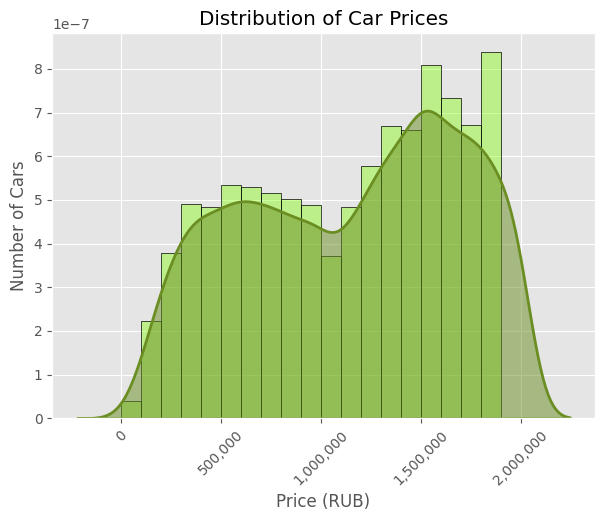

the cheapest cars:['Vito']
the most expensive cars:['C-Class', 'E-Class', 'SLK-Class', 'GL-Class', 'GLA-Class', 'CLA-Class', 'M-Class', 'GLK-Class', 'CL-Class', 'S-Class', 'G-Class', 'CLS-Class', 'Viano', 'GLC-Class', 'R-Class', 'Vito', 'SL-Class', 'B-Class', 'CLK-Class', 'Mercedes', 'Citan']


In [93]:
#the price distribution of all cars

plt.style.use('ggplot')
plt.figure(figsize=(7,5))
bins = np.arange(0, 2000000, 100000)
bins = np.arange(0, 2000000, 100000)
sns.histplot(
    data=data, x="Price", bins=bins,color="chartreuse",edgecolor='black', alpha=0.4,stat="density"
)

sns.kdeplot(
    data=data, x="Price",color="olivedrab",fill=True, alpha=0.5, linewidth=2
)
plt.xticks(rotation=45)
plt.gca().get_xaxis().set_major_formatter(
    mticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
plt.xlabel("Price (RUB)")
plt.ylabel("Number of Cars")
plt.title("Distribution of Car Prices")
plt.show()

data1 = data[["Car","Price"]].copy()
cheapest = data1[data1["Price"] == np.min(data1["Price"])].drop_duplicates()["Car"].str.replace("Mercedes-Benz ","").tolist()
expensive = data1[data1["Price"] == np.max(data1["Price"])].drop_duplicates()["Car"].str.replace("Mercedes-Benz ","").tolist()
print(f"the cheapest cars:{cheapest}")
print(f"the most expensive cars:{expensive}")

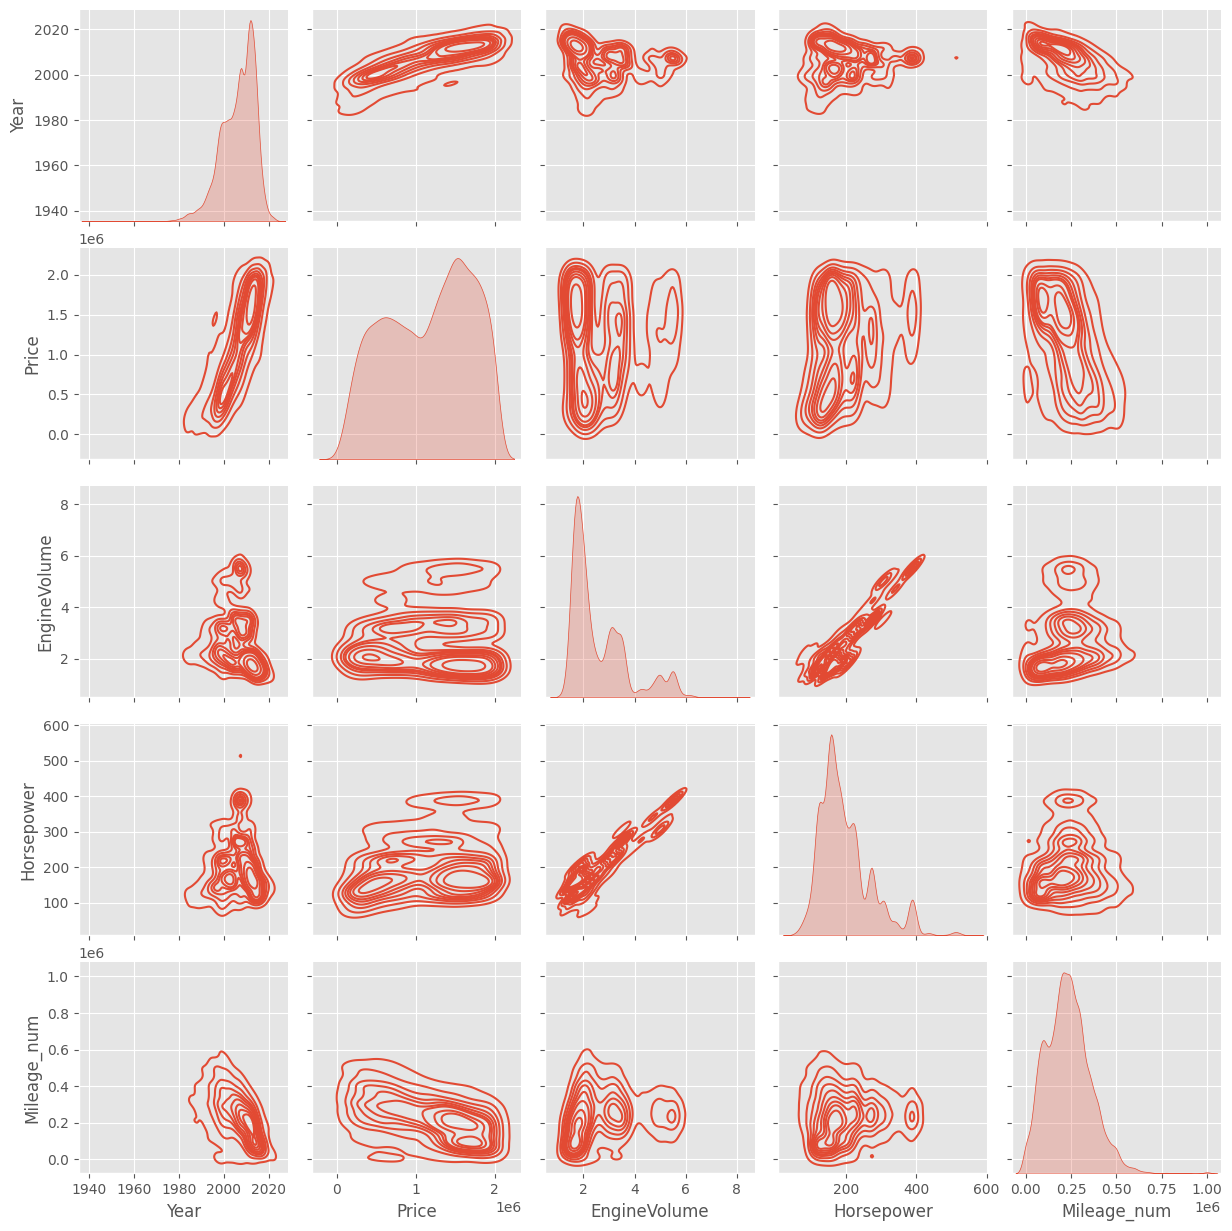

In [24]:
sns.pairplot(data,kind="kde")
plt.show()

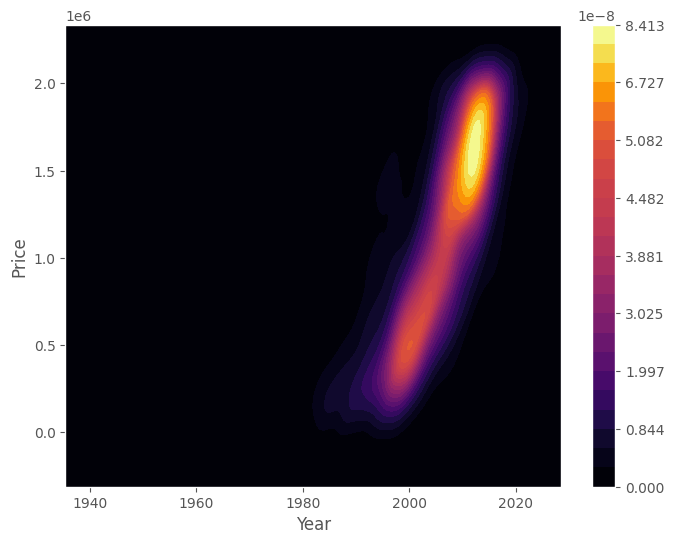

In [26]:
plt.figure(figsize=(8,6))
sns.kdeplot(x="Year",y="Price",data=data,fill=True,cmap="inferno",thresh=0, levels=25,cbar=True)
plt.show()

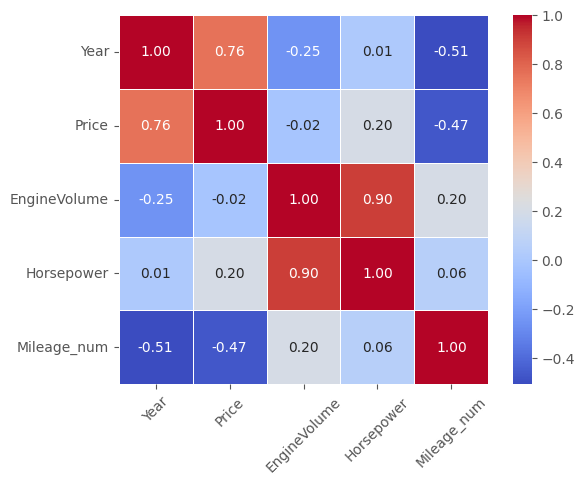

In [30]:
sns.heatmap(data=data.select_dtypes(include=['int64', 'float64']).corr(),annot=True,cmap="coolwarm",fmt=".2f",linewidths=0.5,square=True)
plt.xticks(rotation=45)
plt.show()

In [29]:
data["Car"].unique()

array(['Mercedes-Benz C-Class', 'Mercedes-Benz A-Class',
       'Mercedes-Benz E-Class', 'Mercedes-Benz Mercedes',
       'Mercedes-Benz S-Class', 'Mercedes-Benz 190', 'Mercedes-Benz Vito',
       'Mercedes-Benz W123', 'Mercedes-Benz CLK-Class',
       'Mercedes-Benz M-Class', 'Mercedes-Benz Vaneo',
       'Mercedes-Benz GL-Class', 'Mercedes-Benz R-Class',
       'Mercedes-Benz B-Class', 'Mercedes-Benz GLK-Class',
       'Mercedes-Benz GLA-Class', 'Mercedes-Benz CLS-Class',
       'Mercedes-Benz G-Class', 'Mercedes-Benz CLA-Class',
       'Mercedes-Benz CLC-Class', 'Mercedes-Benz SLK-Class',
       'Mercedes-Benz Viano', 'Mercedes-Benz V-Class',
       'Mercedes-Benz CL-Class', 'Mercedes-Benz GLC-Class',
       'Mercedes-Benz Citan', 'Mercedes-Benz SL-Class',
       'Mercedes-Benz SLC-Class', 'Mercedes-Benz W115'], dtype=object)

Best Mercedes model based on aggregated metrics:
Car             Mercedes-Benz CL-Class
Horsepower                         1.0
EngineVolume                       1.0
Price                         0.266667
Mileage_num                   0.522954
TotalScore                     2.78962
Name: 4, dtype: object


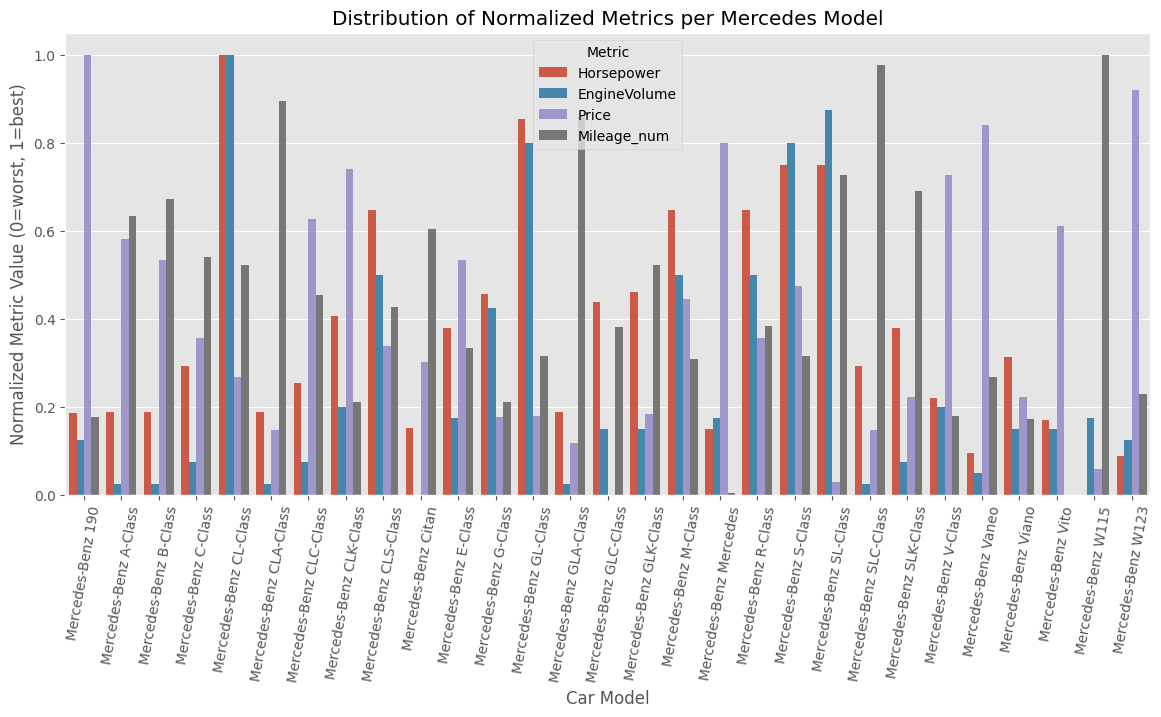

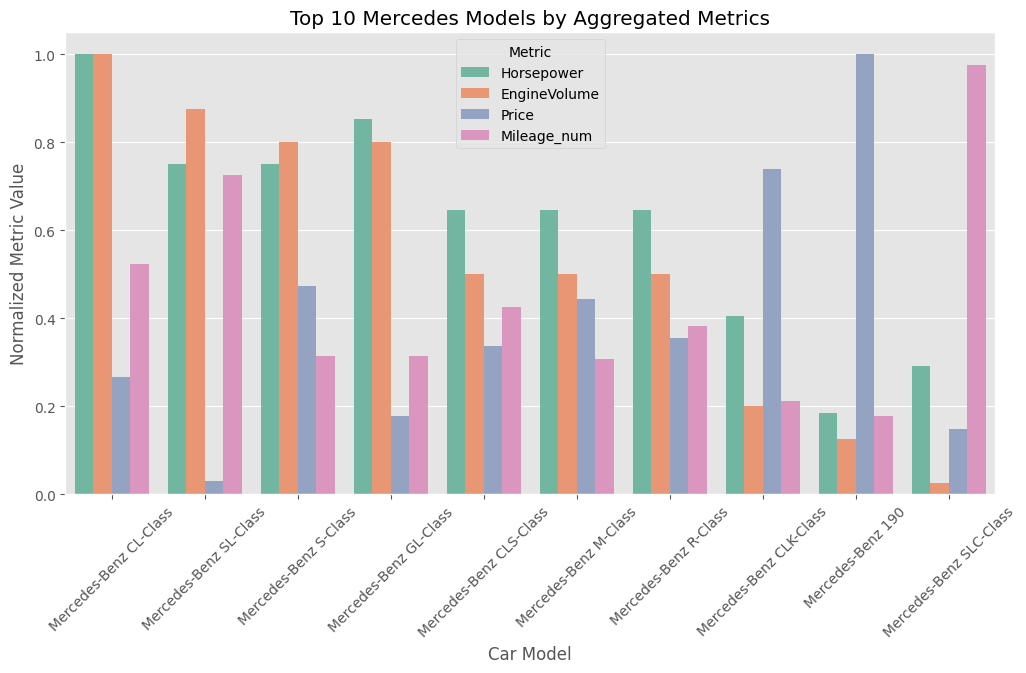

In [79]:
metrics_high = ["Horsepower", "EngineVolume"]
metrics_low  = ["Price", "Mileage_num"]

agg_data = data.groupby("Car")[metrics_high + metrics_low].median().reset_index()

agg_scaled = agg_data.copy()
scaler = MinMaxScaler()

agg_scaled[metrics_high] = scaler.fit_transform(agg_scaled[metrics_high])

agg_scaled[metrics_low] = scaler.fit_transform(agg_scaled[metrics_low])
agg_scaled[metrics_low] = 1 - agg_scaled[metrics_low]

agg_scaled["TotalScore"] = agg_scaled[metrics_high + metrics_low].sum(axis=1)

best_model = agg_scaled.sort_values("TotalScore", ascending=False).iloc[0]
print("Best Mercedes model based on aggregated metrics:")
print(best_model)

metrics_all = metrics_high + metrics_low
melted = agg_scaled.melt(id_vars="Car", value_vars=metrics_all,
                         var_name="Metric", value_name="Value")

# Top 10 models by TotalScore
top10 = agg_scaled.sort_values("TotalScore", ascending=False).head(10)
top10_melted = top10.melt(id_vars="Car", value_vars=metrics_all,
                          var_name="Metric", value_name="Value")

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(14,6))
sns.barplot(data=melted, x="Car", y="Value", hue="Metric", ax=ax)
plt.xticks(rotation=80)
plt.title("Distribution of Normalized Metrics per Mercedes Model")
plt.ylabel("Normalized Metric Value (0=worst, 1=best)")
plt.xlabel("Car Model")
plt.legend(title="Metric")
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(data=top10_melted, x="Car", y="Value", hue="Metric", palette="Set2")
plt.xticks(rotation=45)
plt.title("Top 10 Mercedes Models by Aggregated Metrics")
plt.ylabel("Normalized Metric Value")
plt.xlabel("Car Model")
plt.legend(title="Metric")
plt.show()

C:\Temp\ipykernel_19724\4247217456.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


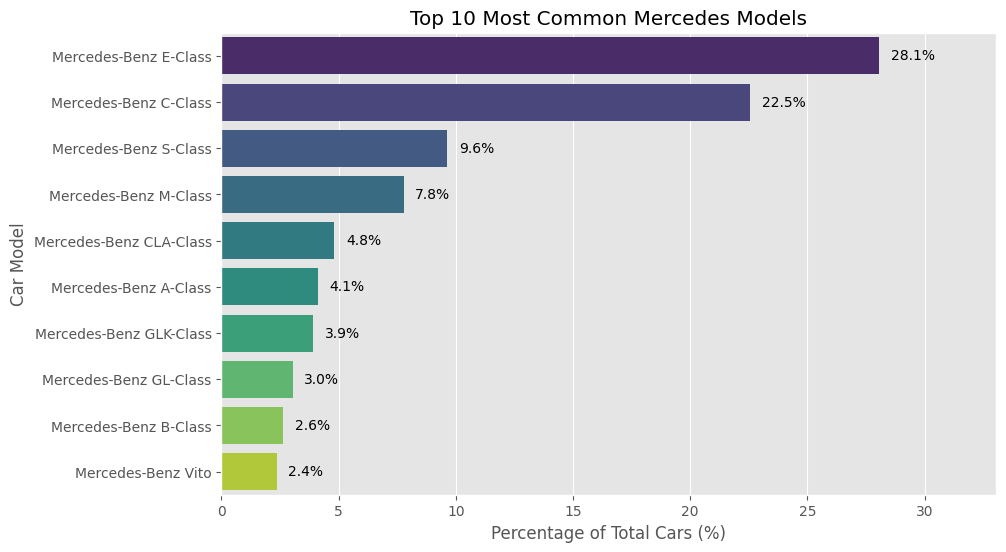

In [80]:
car_counts = data["Car"].value_counts().reset_index()
car_counts.columns = ["Car", "Count"]

car_counts["Percentage"] = 100 * car_counts["Count"] / car_counts["Count"].sum()

top_cars = car_counts.head(10)

plt.figure(figsize=(10,6))
sns.barplot(
    data=top_cars, 
    y="Car", 
    x="Percentage", 
    palette="viridis"
)

for index, row in top_cars.iterrows():
    plt.text(row["Percentage"] + 0.5, index, f'{row["Percentage"]:.1f}%', va='center')

plt.title("Top 10 Most Common Mercedes Models")
plt.xlabel("Percentage of Total Cars (%)")
plt.ylabel("Car Model")
plt.xlim(0, top_cars["Percentage"].max() + 5)
plt.show()

C:\Temp\ipykernel_19724\4208550600.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities.values, y=top_cities.index, palette="viridis")


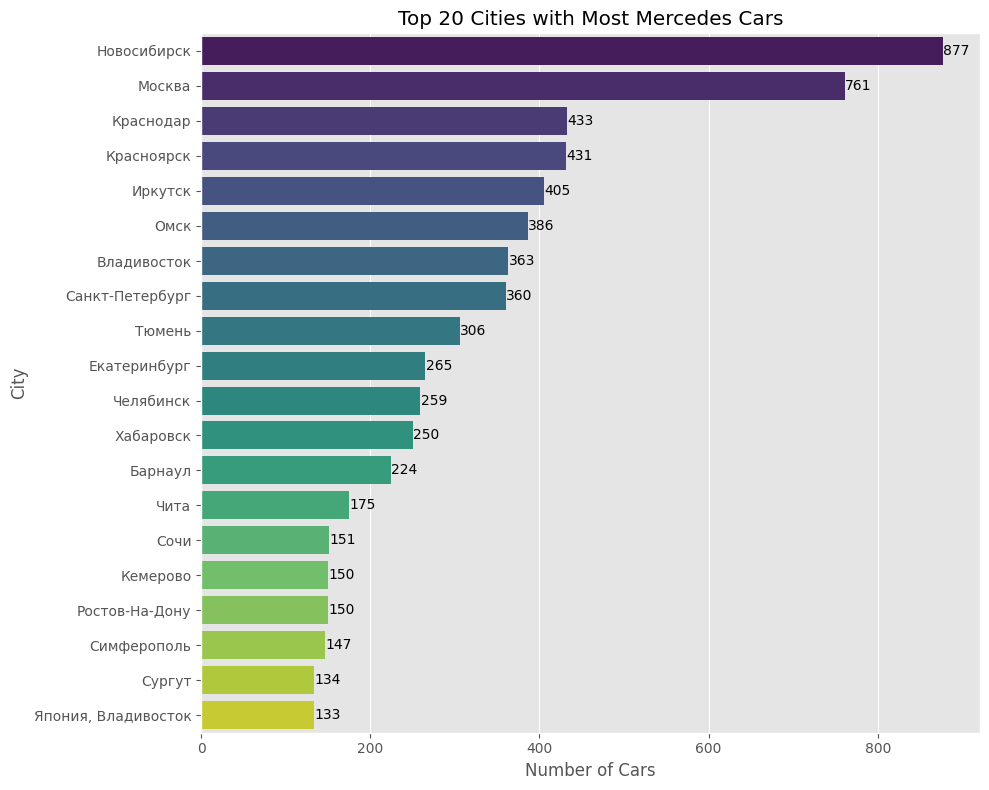

In [86]:
city_counts = data["Location"].value_counts()
top_cities = city_counts.head(20)

plt.figure(figsize=(10,8))
sns.barplot(x=top_cities.values, y=top_cities.index, palette="viridis")

for i, v in enumerate(top_cities.values):
    plt.text(v + 0.5, i, f"{v}", va='center')  # show count

plt.xlabel("Number of Cars")
plt.ylabel("City")
plt.title("Top 20 Cities with Most Mercedes Cars")
plt.tight_layout()
plt.show()

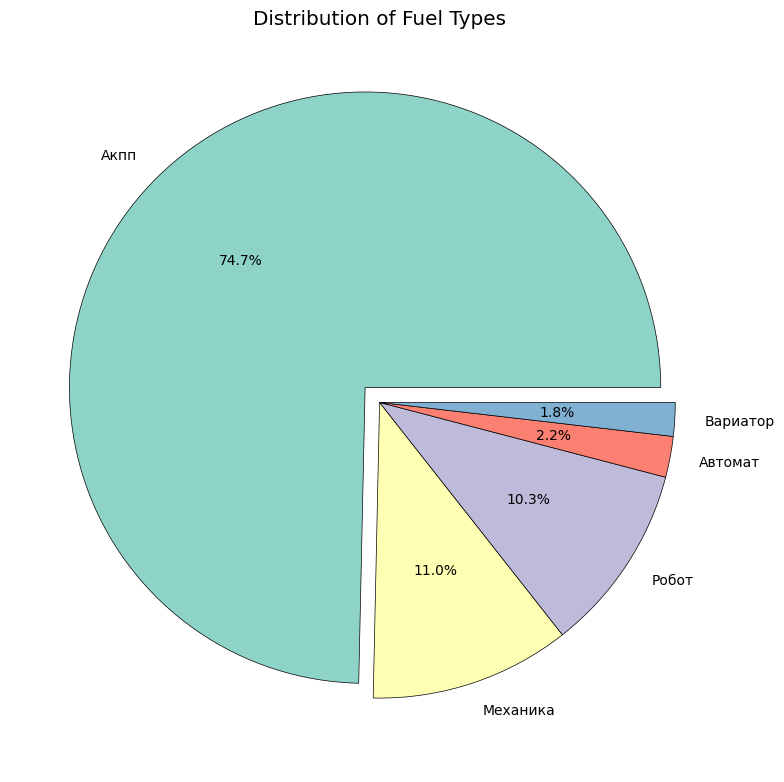

In [111]:
fuel_counts = data["Transmission"].value_counts()

plt.figure(figsize=(8,8))
plt.pie(fuel_counts.values, 
        labels=fuel_counts.index, 
        autopct='%1.1f%%',         
        colors=plt.cm.Set3.colors,
        explode=[0.07,0,0,0,0],
        wedgeprops={"edgecolor": "black"})

plt.title("Distribution of Fuel Types")
plt.tight_layout()
plt.show()